In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Inspect the tables to get the column names
inspector = sqlalchemy.inspect(engine)
columns = inspector.get_columns('measurement')
print("Measurement Columns")
for column in columns:
    print('-',column["name"],'-',column["type"])
print("\nStation Columns")
columns = inspector.get_columns('station')
for column in columns:
    print('-',column["name"],'-', column["type"])

Measurement Columns
- id - INTEGER
- station - TEXT
- date - TEXT
- prcp - FLOAT
- tobs - FLOAT

Station Columns
- id - INTEGER
- station - TEXT
- name - TEXT
- latitude - FLOAT
- longitude - FLOAT
- elevation - FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

print(f'The most recent date in the data set is {recent_date}')

The most recent date in the data set is ('2017-08-23',)


ConversionError: Failed to convert value(s) to axis units: ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']

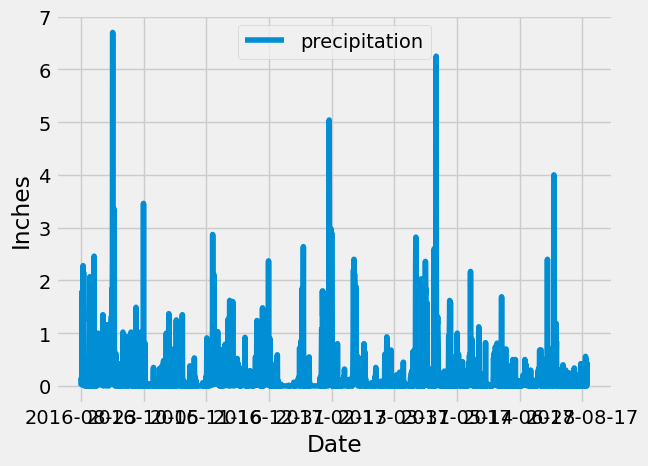

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).filter(measurement.prcp != 'null').\
    filter(measurement.date >=  (dt.date(2017,8,23)- dt.timedelta(days=365))).\
    order_by(measurement.date).all()    

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns =['date','precipitation'])
df.set_index('date', inplace = False)
# Sort the dataframe by date
# df.sort_index(ascending=True)
example_dates = ['2016-08-23','2016-10-01','2016-11-09',
                 '2016-12-19','2017-01-28','2017-03-09',
                 '2017-04-18','2017-05-31','2017-07-10']
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line('date','precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

plt.xticks(example_dates, rotation='90')

plt.legend(['Precipitation'], loc="upper right",facecolor='white')

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
st_query = session.query(measurement.station).distinct().count()
print(f' Total number of station in the dataset is {st_query}')

 Total number of station in the dataset is 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [measurement.station,
       func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]

stats = session.query(*sel).\
    filter(measurement.station == 'USC00519281').\
    group_by(measurement.station).\
    order_by(measurement.station).all()

#print results
stats = pd.DataFrame(stats, columns =['station id','lowest_temp','highest_temp','avg_temp'])
stats= stats.to_string(index=False)

print(stats)



 station id  lowest_temp  highest_temp  avg_temp
USC00519281         54.0          85.0 71.663781


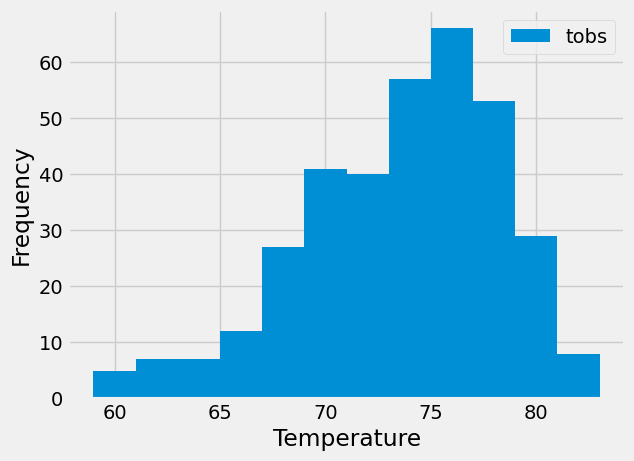

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
gloop = session.query(measurement.date,measurement.station, measurement.tobs).\
    filter(measurement.date >=  (dt.date(2017,8,23)- dt.timedelta(days=365))).\
    filter(measurement.station == 'USC00519281').\
    order_by(measurement.date).all() 

df2 = pd.DataFrame(gloop, columns =['date','station','tobs'])

df2.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()

# Close session

In [17]:
# Close Session
session.close()